In [1]:
# Note: Make sure your dump file has sorted atom id
# make sure the z-position is in the 4th location

In [2]:
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cmath

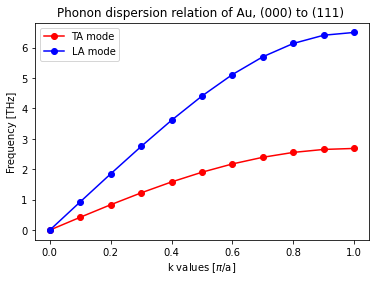

In [3]:
# Phonon dispersion relation values:
# These values should be obtained from Phonon-dispersion relation of Au 
TA_freq = np.array([0, 422531609399.84, 834200909849.15, 1224563660601.91, 1583947824780.52, 
                 1903668508126.36, 2176185219999.14, 2395114621687.84, 2555327626841.41, 
                 2653016453446.38, 2685847412572.21])  # frequency in Hz
LA_freq = np.array([0, 928780803795.77, 1849542776769.78, 2750148874370.31, 3611995172904.95,
                        4410212916740.89, 5116139573866.81, 5700820244640.96, 6138553474768.24,
                        6409474658336.53, 6501180691475.74])

TA_freq_THz = TA_freq/1e12; 
LA_freq_THz = LA_freq/1e12;
k_val = np.arange(0.0, 1.1, 0.1); k_val[9]

plt.plot(k_val, TA_freq_THz, 'o-r', label='TA mode')
plt.plot(k_val, LA_freq_THz, 'o-b', label='LA mode')
plt.xlabel('k values [$\pi$/a]')
plt.ylabel('Frequency [THz]')
plt.title('Phonon dispersion relation of Au, (000) to (111) ')
plt.legend()
plt.show()


In [4]:
# Input variables:
a = 4.0782             # lattice parameter of Au
A = 0.002                # Amplitude of the wave in angstrom
eps_k0 = 1             # e(k0) = Polarization wave vector, why 1?
gamma = 50*a           # Spatial extent
val = 4
k0 = k_val[val]*np.pi/a  # wave vector, k0 = 0.9*pi/a
w_LA = LA_freq[val]      # in Hz, LA freq corresponding to k0 = 0.9*pi/a
w_TA = TA_freq[val]      # in Hz, TA freq corresponding to k0 = 0.9*pi/a

# Structural variable:
N_atoms = 358560  # Number of atoms
N_layer = 996     # Number of Au(111) layers
N_layeratom = 360 # Number of atoms in each Au(111) layer N_atoms/N_layer

In [5]:
# Now take the original structure after Energy minimization and instill the phonon wave-packet
offset_p = 19
N_atoms = 358560

print("Original position: data.npt50psaurelax_EM")
with open("data_cg_boxrelax.npt50psaurelax_EM", "r") as file:
    lines = file.readlines()

# Read position data:
plines = lines[offset_p:(N_atoms+offset_p)]
# Extract data from line 19 to 358579
position = np.array([list(map(float, line.strip().split())) for line in plines])
print("Shape of position:", position.shape)

# Read velocity data:
offset_v = N_atoms+offset_p + 3
vlines = lines[offset_v:(N_atoms+offset_v)]
# Extract data from line 19 to 358579
velocity = np.array([list(map(float, line.strip().split())) for line in vlines])
print("Shape of velocity:", velocity.shape)

Original position: data.npt50psaurelax_EM
Shape of position: (358560, 10)
Shape of velocity: (358560, 4)


In [6]:
# Sorting the position according to Z-position:
sorted_index = np.argsort(position[:, 6])
position = position[sorted_index]            # col 4 = x, col 5 = y, col 6 = z

# Sorting the velocity according to atomid:
v_index = np.argsort(velocity[:, 0])
velocity = velocity[v_index]; 

2340.6464846223594
-2.6007416136501784


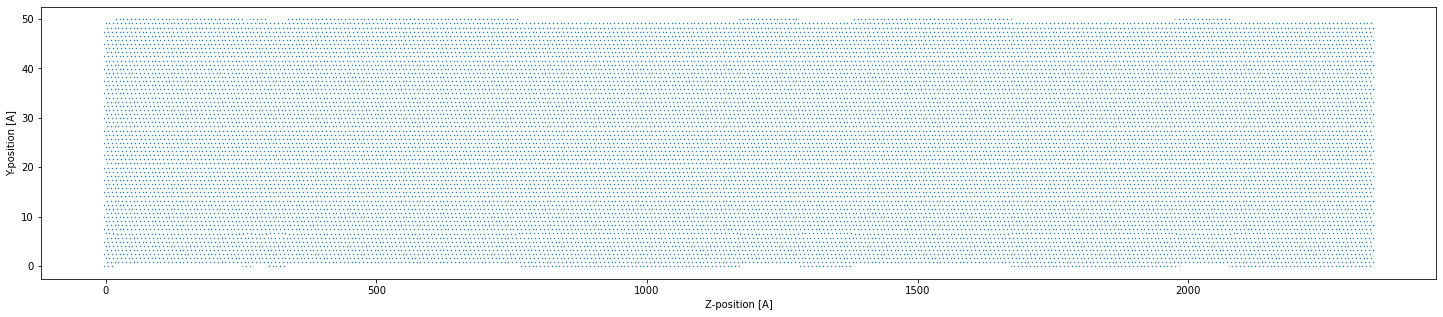

In [7]:
maxZ = np.max(position[:, 6]); print(maxZ)
minZ = np.min(position[:, 6]); print(minZ)

# position[:, 6] = position[:, 6] - minZ       # shifting the lower limit to zero

plt.figure(figsize =(25, 5))
plt.plot(position[:, 6], position[:, 5], '.', markersize=0.1)
plt.xlabel('Z-position [A]')
plt.ylabel('Y-position [A]')
plt.show()

In [8]:
# Calculating Au layers:
N_layers = position.shape[0] // N_layeratom   # Number of Au layers

# initialize the new array
Au_layers = np.zeros((N_layers, 1)) # Creating empty array

# loop over the number of averages
for i in range(N_layers):
    start = i * N_layeratom
    end = (i + 1) * N_layeratom
    
    # calculate the average of every 360 rows
    avg = np.mean(position[start:end, 6], axis=0)
    
    # store the average in the new array
    Au_layers[i, 0] = avg
Au_layers = Au_layers.reshape(-1)         

In [9]:
# Computing the displacements
xn = Au_layers                             # All positions
x0 = Au_layers[Au_layers.shape[0]//2]      # middle of the Au layer, for 2600 A

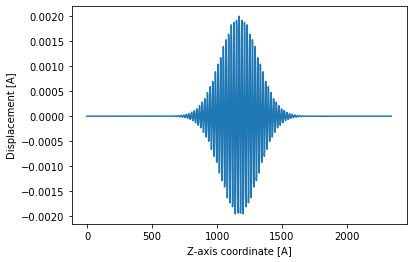

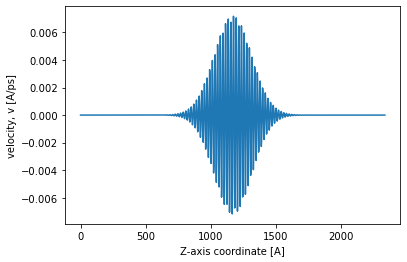

In [10]:
y = 0 + k0*(xn - x0)*1j
disp = A*eps_k0*np.exp(-(xn - x0)**2/gamma**2)*np.exp(y)

# Plot the position
U = np.real(disp)                        # Take the real part for displacement
plt.plot(xn, U)
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("Displacement [A]")
# plt.xlim(800, 1800)
# plt.ylim(-0.2, 0.2)
plt.show()

# Plot the velocity
vel = (w_LA*np.imag(disp))/1e12           # For LA mode set this as velocity in z-dirn, A/ps            
plt.plot(xn, vel)
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("velocity, v [A/ps]")
# plt.xlim(800, 1800)
# plt.ylim(-0.5, 0.5)
plt.show()

In [11]:
# Original_position # All positional coordinate
# xn                # Z-coordinate of each layer
# U;                 # Phonon wave at t = 0 ps

In [12]:
offset_p = 9
N_atoms = 358560
dump_z_pos = 4                           # 4 for LAMMPs produced
with open("dumps-1_NVE.lmc", "r") as file:
    lines = file.readlines()

In [13]:
Total_lines = len(lines)                    # Total no. of lines
Total_frames = Total_lines//(N_atoms + 9)    # Count all the frames

In [14]:
Z_pos = np.zeros((N_atoms, Total_frames)) # 358560 X 14(frames)

offset_p = 9

for i in np.arange(Total_frames):
    # Read position data:
    a = int(N_atoms*i + offset_p*(i+1))
    b = int((N_atoms + offset_p)*(i+1))
    plines = lines[a:b]

    dump_pos = np.array([list(map(float, line.strip().split())) for line in plines])
#     print("Shape of position:", dump_pos.shape)
    Z_pos[:, i] = dump_pos[:, dump_z_pos]

# Z_pos has data in following way
# data saved every 15000 steps, dt=0.0005 ps, so frames every 7.5 ps
# t=0, t=7.5 ps, t=15 ps ...
# these Z-positions are ordered according to atom id

In [15]:
# Sorting the Z-position according to atom id:
sorted_index = np.argsort(position[:, 0])
Original_position = position[sorted_index]      # col 4 = x, col 5 = y, col 6 = z

In [16]:
# Calculating the difference between new atomic position and Original Z-position
diff = Z_pos - Original_position[:, 6][:, None] @ np.ones(Total_frames)[None, :]

In [17]:
# This array have data in following order
# atom id (arranged) [Z-position Differences a/c to atom id]  
new_arr = np.hstack((Original_position[:, 0][:, None], Original_position[:, 6][:, None], diff))

# Now lets sort this array according to 2nd column, i.e, the Z-position
sort_index = np.argsort(new_arr[:, 1])
new_arr = new_arr[sort_index]        # col 1 = atom id, col 2 = sorted Z-position, col 3: = Z-pos diff

In [18]:
new_arr.shape

(358560, 13)

In [19]:
# Fixing the issue due periodic boundary condition:
# This issue arises when atoms at the boundary move during the simulation
# So, the total box-length should be added or subtracted based on atom position

Lz = 2345.6    # Length of box in Z-direction in Angstrom
new_arr[:, 2:] = np.where(new_arr[:, 2:] < -100,  Lz + new_arr[:, 2:], new_arr[:, 2:])
new_arr[:, 2:] = np.where(new_arr[:, 2:] >  100,  Lz - new_arr[:, 2:], new_arr[:, 2:])

In [20]:
# Now lets average the atoms in each layers

# initialize the new array
phonon_wave = np.zeros((N_layers, Total_frames)) # Creating empty array

# loop over the number of averages
for i in range(N_layers):
    start = i * N_layeratom
    end = (i + 1) * N_layeratom
    
    # calculate the average of every 360 rows
    avg = np.mean(new_arr[:, 2:][start:end, :], axis=0)
    
    # store the average in the new array
    phonon_wave[i, :] = avg


In [21]:
np.savetxt("PW_simulation_50ps_A002_k4.dat", phonon_wave)

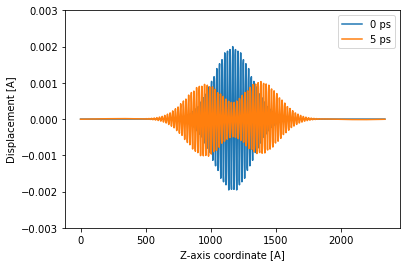

In [34]:
phonon_wave.shape

# Plot the position
plt.plot(xn[1:], phonon_wave[1:, 0], label='0 ps')
plt.plot(xn[1:], phonon_wave[1:, 1], label='5 ps')
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("Displacement [A]")
# plt.xlim(500, 550)
plt.ylim(-0.003, 0.003)
plt.legend()
plt.savefig("Wave-packetmotion5ps_novel.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()